This tutorial summarizes the tools to predict the LIM outcomes of Zeus21.

In [65]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from matplotlib.cm import get_cmap

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

Set up the cosmology, astrophysics and the line parameters.

In [66]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [67]:
#set up your parameters here, as an example the CDM (reduced) density
omega_cdm = 0.12
CosmoParams_input = zeus21.Cosmo_Parameters_Input(omegac = omega_cdm)
ClassyCosmo = zeus21.runclass(CosmoParams_input)
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [68]:
LineParams_input_small = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 0.5,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

LineParams_input_med = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 3.,
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

LineParams_input_large = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 10., 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

In [69]:
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

LineParams_small = zeus21.Line_Parameters(LineParams_input_small) 
LineParams_med = zeus21.Line_Parameters(LineParams_input_med) 
LineParams_large = zeus21.Line_Parameters(LineParams_input_large) 
CorrFClass_small = zeus21.Correlations_LIM(LineParams_small, CosmoParams, ClassyCosmo)
CorrFClass_med = zeus21.Correlations_LIM(LineParams_med, CosmoParams, ClassyCosmo)
CorrFClass_large = zeus21.Correlations_LIM(LineParams_large, CosmoParams, ClassyCosmo)
print('Correlation functions saved.')

#set up your astro parameters too, here the peak of f*(Mh) as an example
AstroParams = zeus21.Astro_Parameters(CosmoParams)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)
CoeffStructure_small = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_small, zmin=ZMIN)
CoeffStructure_med = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_med, zmin=ZMIN)
CoeffStructure_large = zeus21.get_LIM_coefficients(CosmoParams,  AstroParams, HMFintclass, LineParams_large, zmin=ZMIN)

zlist = CoeffStructure_21.zintegral
print('LIM and coefficients stored. Move ahead.')

HMF interpolator built. This ends the cosmology part -- moving to astrophysics.
Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc
Correlation functions saved.
LIM and coefficients stored. Move ahead.


The standard Zeus21 consider the $\rm SFRD$ from Gallumi and it introduces a deterministic relation between this quantity and $M_h$, such that 

${\rm SFRD} [M_\odot/{\rm yr }/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}}d\log_{10}M_h M_h\dfrac{dn}{dM_h}{\rm SFR}(M_h)$

Text(0, 0.5, '$\\rm SFRD [M_\\odot/{\\rm yr}/{\\rm Mpc}^3]$')

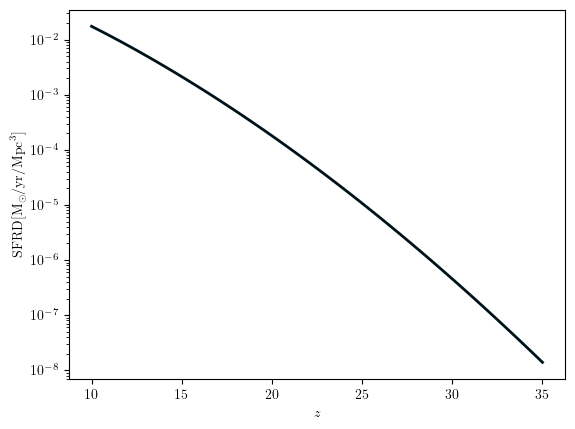

In [70]:
plt.semilogy(CoeffStructure_21.zGreaterMatrix[:,0],CoeffStructure_21.SFRDbar2D_II[:,0])
plt.xlabel(r'$z$')
plt.ylabel(r'$\rm SFRD [M_\odot/{\rm yr}/{\rm Mpc}^3]$')

First of all, we consider the relation between the luminosity of the CII line and the SFR, as modelled by Lagache et al. (2018) https://www.aanda.org/articles/aa/pdf/2018/01/aa32019-17.pdf. 
Such relation is defiend as follows.

$\log_{10} \dfrac{L}{L_\odot} = \alpha_{\rm SFR}\log_{10}\dfrac{\rm SFR}{M_\odot/{\rm yr}}+\beta_{\rm SFR}$

$\alpha_{\rm SFR} = 1.4 - 0.07z $

$\beta_{\rm SFR} = 7.1-0.07z$

The first issue we face is that above $z=20$ the $\alpha_{\rm SFR}$ coefficient becomes negative, implying that the luminosity would get larger for smaller, less star forming halos. To overcome this issue, for the moment we consider the case of constant parameters in $z$, $\alpha_{\rm SFR} = 1.4 -0.07\times 10 = 0.7$ and $\beta_{\rm SFR} = 7.1-0.07\times 10 = 6.4$.

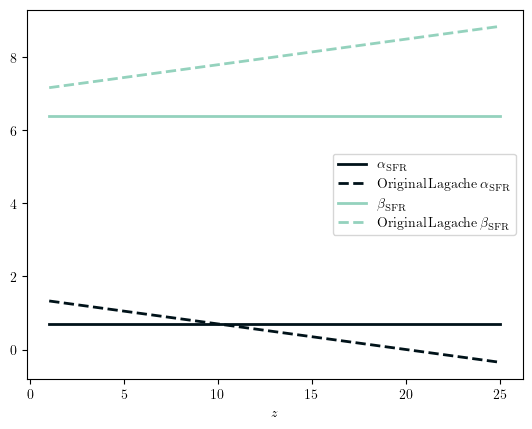

In [71]:
z_test_LIM = np.linspace(1.,25.)

alpha_SFR = lambda z: LineParams_small.CII_alpha_SFR_0 + LineParams_small.CII_alpha_SFR_z*z
beta_SFR = lambda z: LineParams_small.CII_beta_SFR_0 + LineParams_small.CII_beta_SFR_z*z

alpha_SFR_1 = lambda z: 1.4 -0.07*z
beta_SFR_1 = lambda z: 7.1 + 0.07*z

plt.plot(z_test_LIM,alpha_SFR(z_test_LIM),label=r'$\alpha_{\rm SFR}$')
plt.plot(z_test_LIM,alpha_SFR_1(z_test_LIM),color=colors[0],ls='--',label=r'$\rm Original\, Lagache\, \alpha_{\rm SFR}$')
plt.plot(z_test_LIM,beta_SFR(z_test_LIM),color=colors[3],label=r'$\beta_{\rm SFR}$')
plt.plot(z_test_LIM,beta_SFR_1(z_test_LIM),color=colors[3],ls='--',label=r'$\rm Original\, Lagache\, \beta_{\rm SFR}$')
plt.xlabel(r'$z$')
plt.legend()

We then model the average luminosity density, as 

$\rho_L [L_\odot/{\rm Mpc}^3] = \int_{M_h^{\rm min}}^{M_h^{\rm max}} d\log_{10}M_h M_h\dfrac{dn}{dM_h}L({\rm SFR}(M_h))$    

where the array that we create has dimension $N_z \times 1$, in analogy to the $\rm SFRD$ case of the standard Zeus21, which has size $N_z\times N_{R}$, being $R$ the array of smoothing scales used in the peak background split.

The luminosity simply decreases in $z$ due to the choice of $\alpha_{\rm SFR}$ and $\beta_{\rm SFR}$.

Text(0, 0.5, '$\\rho_L [L_\\odot/{\\rm Mpc}^3]$')

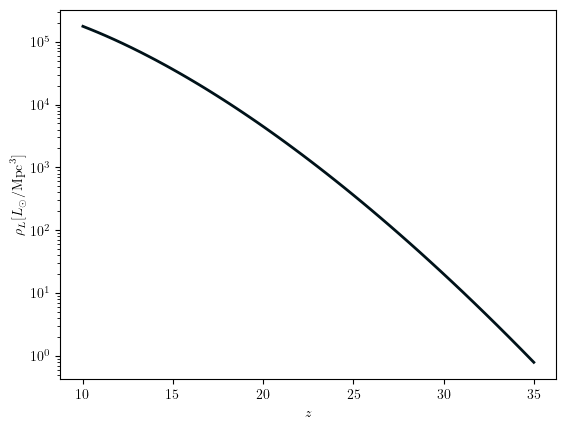

In [72]:
plt.semilogy(CoeffStructure_small.zGreaterMatrix,CoeffStructure_small.rhoLbar)
plt.xlabel(r'$z$')
plt.ylabel(r'$\rho_L [L_\odot/{\rm Mpc}^3]$')


In the original Zeus21, 

${\rm SFRD}(x,R) = (1+\delta_R)\int dM_h \dfrac{dn}{dM_h}(\delta_R)\dot{M}_* \sim \bar{\rm SFRD}e^{\gamma_R\tilde{\delta}_R}$

We consider 

Linear approximation (for the two point function): 
$\exp((\gamma_R \delta_R)^2) \sim 1+(\gamma\delta^2)$

Non linear correction: 
$\exp((\gamma_R \delta_R)^2) - (1+(\gamma\delta)^2)$

The next step is to model the average intensity/brightness temperature measured in the survey, as 

$\bar{I}_\nu [L_\odot {\rm/cm^2/sr/Hz}] \,= \dfrac{c}{4\pi H(z)\nu_{\rm rest}}{\rho}_L(z)$

$\qquad \quad\qquad \bar{T}_\nu [\mu K] = \dfrac{c^3(1+z^2)}{8\pi k_B H(z)\nu_{\rm rest}^3}{\rho}_L(z)$

$\qquad\qquad\qquad\qquad\,\, = c_1^{\rm LIM}(z)c_2^{\rm LIM}(z)$

Note that, differently from the standard Zeus21 case, both the coefficients only depend on $z$ and not on $R$. We continue using $\bar{T}_\nu$.

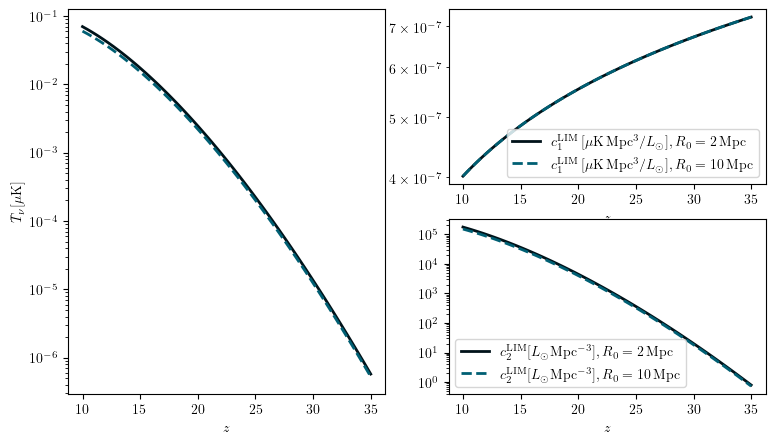

In [73]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.semilogy(zlist,CoeffStructure_small.Inu_avg, label = r'$R_0 = %g\,{\rm Mpc}$'%LineParams_small._R)
plt.semilogy(zlist,CoeffStructure_large.Inu_avg, '--',label = r'$R_0 = %g\,{\rm Mpc}$'%LineParams_large._R)
plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{T}_{\nu} [\mu {\rm K}]$')

plt.subplot(222)
plt.semilogy(zlist,CoeffStructure_small.coeff1_LIM,label=r'$c_1^{\rm LIM}\,[\mu {\rm K\,Mpc^3}/L_\odot],\,$' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_small._R)
plt.semilogy(zlist,CoeffStructure_large.coeff1_LIM,'--',label=r'$c_1^{\rm LIM}\,[\mu {\rm K\,Mpc^3}/L_\odot]$,\,' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_large._R)
plt.xlabel(r'$z$')
plt.legend()

plt.subplot(224)
plt.semilogy(zlist,CoeffStructure_small.coeff2_LIM,label=r'$c_2^{\rm LIM} [L_\odot{\rm Mpc^{-3}}],\,$' + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_small._R)
plt.semilogy(zlist,CoeffStructure_large.coeff2_LIM,'--',label=r'$c_2^{\rm LIM} [L_\odot{\rm Mpc^{-3}}],\,$'  + r'$R_0 = %g\,{\rm Mpc}$'%LineParams_large._R)
plt.xlabel(r'$z$')
plt.legend(loc=3)

In [74]:
print('bar_T =' + str(CoeffStructure_small.Inu_avg[0]))

bar_T =0.07024866909098712


We now proceed to compute the LIM auto-correlation and power spectrum. 

First of all, we define the tophat window function $W(k,R_0)$, where $R_0$ is the $\_R$ resolution value that we plugged in the Line Parameters. We here compare two cases, $R_0 = 10 {\rm Mpc}$ and $R_0 = 2 {\rm Mpc}$ (which is the one that then we use in the main analysis), where all the other line parameters are the same.

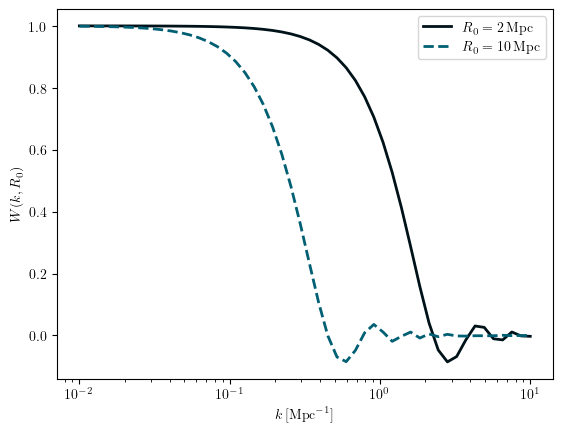

In [75]:
k = np.logspace(-2,1)
W_3 = CorrFClass_small.Window(k,LineParams_small._R)
W_50 = CorrFClass_large.Window(k,LineParams_large._R)

plt.semilogx(k,W_3,label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_small._R)
plt.semilogx(k,W_50,'--',label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_large._R)
plt.xlabel(r'$k\,[{\rm Mpc}^{-1}]$')
plt.ylabel(r'$W(k,R_0)$')
plt.legend()

And we then compute the linear matter correlation function smoothed over these windows, namely

$\xi(r) = {\rm FT}[P(k)W_{R_0}(k)^2]$

This array has size $N_{R_S} \times N_{R_S} \times N_k = 1 \times 1 \times N_z$.

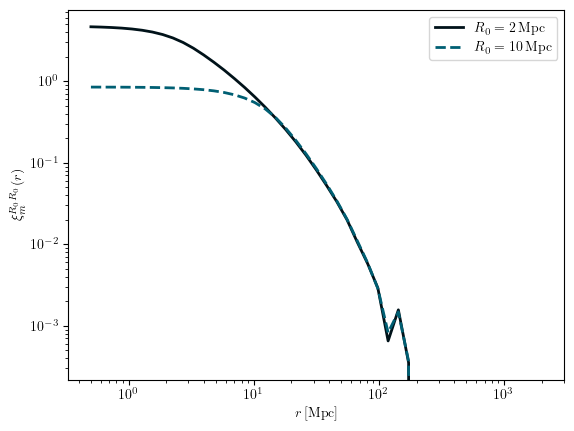

In [76]:
xi_3 = CorrFClass_small.xi_LIMLIM_CF
xi_50 = CorrFClass_large.xi_LIMLIM_CF

plt.loglog(CorrFClass_small.rlist_CF,xi_3[0,0,:],label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_small._R)
plt.loglog(CorrFClass_large.rlist_CF,xi_50[0,0,:],'--',label=r'$R_0 = %g\,{\rm Mpc}$'%LineParams_large._R)
plt.xlabel(r'$r\,[{\rm Mpc}]$')
plt.ylabel(r'$\xi_m^{R_0R_0}(r)$')
plt.legend()

We now study the Power Spectrum module.

In [77]:
RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PSLIM_small = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams, LineParams_small, CorrFClass_small, 'here we will put 21cm coeffs', CoeffStructure_small, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

Computed the LIM power spectrum.


In [78]:
PSLIM_large = zeus21.Power_Spectra_LIM(CosmoParams, AstroParams,LineParams_large, CorrFClass_large, 'here we will put 21cm coeffs', CoeffStructure_large, RSD_MODE = RSDMODE)
print('Computed the LIM power spectrum.')

Computed the LIM power spectrum.


To compare, we also extract the 21cm power spectrum.

In [79]:
CorrFClass_21 = zeus21.Correlations(CosmoParams, ClassyCosmo)
PS21 = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFClass_21, CoeffStructure_21, RSD_MODE = RSDMODE)
print('Computed the 21cm power spectrum.')

Computed the 21cm power spectrum.


The module computes the window $c_1^{\rm LIM}c_2^{\rm LIM}\gamma_{R_0}^{\rm LIM}D(z)$, which has size $N_z\times 1$ and it is then squared and applied to the power spectrum. 

Note that in the 21cm original code such window was $R$ dependent, hence it was transformed as
$ \tilde{W}^{\rm 21cm}_{R}(z,k) = {\rm FT}[{W_{\rm 21cm}(R)\times Rd\log R}/{4\pi R^2}]$

where $W_{\rm 21cm}=c^{21}_1(z)c^{21}_2(R,z)$ the $r$ factor is introduced to perform the FFT, which gives it size $N_z \times N_{r(k)}$. 

In the original Zeus21, at this point they compare the $R_{1,2}$ scales where $\xi^{R_1R_2}(r)$ is computed, with the range $[R_{NL}^{min},R_{NL}^{max}]=[2,100]$ Mpc where the non-linear corrections plotted above are not negligible. Correlations on scales smaller than $2$ Mpc are simply set equal to the one at 2 Mpc to avoid problematics, while scales larger than 100 Mpc are treated linearly. 

For scales that are between the non-linear regime, they recompute:

$C_{XL} = \exp(\gamma_{R_1}\gamma_{R_2}\xi_{NL})-1-\gamma_{R_1}\gamma_{R_1}\xi_{NL}$

$\delta_{x_i}^\alpha = \sum_{R_1R_2} c_{1,\alpha}c_{2,R_1}c_{2,R_2}C_{NL}$

This term is then Fourier transformed into the non linear contribution to the power spectrum, $P^{NL}(k)$.

In our case, we simply compare the resolution scale $R_0$ with the $R_{NL}$ range, and we include the non linear correction $\delta_{x_i}^{\rm LIM}$ in the case in which it is comparable.

#### WE STILL MISS THE DO_DELENS FLAG!

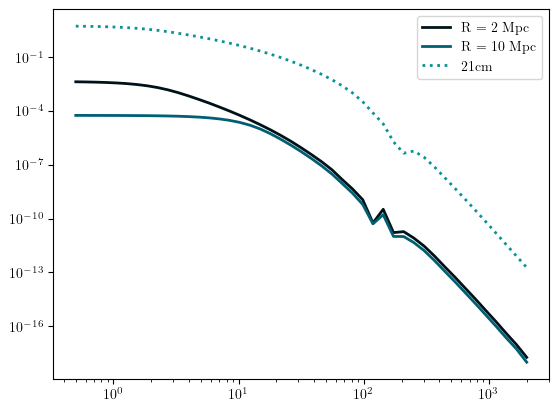

In [80]:
plt.loglog(PSLIM_small._rs_input_mcfit, PSLIM_small._deltaxi_LIM[0,:], label = 'R = %g Mpc'%LineParams_small._R)
plt.loglog(PSLIM_large._rs_input_mcfit, PSLIM_large._deltaxi_LIM[0,:], label = 'R = %g Mpc'%LineParams_large._R)
plt.loglog(PS21._rs_input_mcfit, PS21._II_deltaxi_xa[0,:], label = '21cm',ls=':')
plt.legend()

Finally, we define the linear power spectrum as

$P_{\rm LIM}^{\rm lin}(k,z) = \tilde{W}_{R_O}^{\rm LIM}(k,z)^2 P_m^{\rm lin}(k)$ 

$(\Delta_{\rm LIM}^{\rm lin})^2 = \dfrac{k^3}{2\pi^2}P_{\rm LIM}^{\rm lin}$

and we add the non linear corrections if needed through

$\Delta_{\rm LIM}^2 = (\Delta_{\rm LIM}^{\rm lin})^2 + \dfrac{k^3}{2\pi^2}{\rm FT}(\delta_{x_i}^{\rm LIM})$


(1e-08, 100.0)

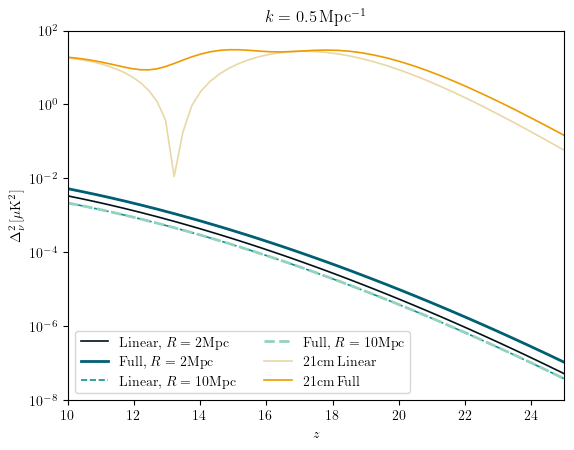

In [81]:
#choose a k to plot
klist = PSLIM_small.klist_PS
klist_21 = PS21.klist_PS
kchoose=0.5;
_ik = min(range(len(klist)), key=lambda i: np.abs(klist[i]-kchoose))
#_ik_05 = min(range(len(klist_05)), key=lambda i: np.abs(klist_05[i]-kchoose))
_ik_21 = min(range(len(klist_21)), key=lambda i: np.abs(klist_21[i]-kchoose))

plt.title(r'$k = %g\,{\rm Mpc^{-1}}$'%kchoose)
plt.semilogy(zlist,PSLIM_small.Deltasq_LIM_lin[:,_ik],'-', linewidth=1.2, label=r'$\rm Linear$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R, )
plt.semilogy(zlist,PSLIM_small.Deltasq_LIM[:,_ik],'-' , label = r'$\rm Full$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R,)

plt.semilogy(zlist,PSLIM_large.Deltasq_LIM_lin[:,_ik],'--', linewidth=1.2, label=r'$\rm Linear$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_large._R )
plt.semilogy(zlist,PSLIM_large.Deltasq_LIM[:,_ik],'--' , label=r'$\rm Full$' + r'$,\,R= %g{\rm Mpc}$'%LineParams_large._R )

plt.semilogy(zlist,PS21.Deltasq_T21_lin[:,_ik],'-', linewidth=1.2, label=r'$\rm 21cm\, Linear$'  )
plt.semilogy(zlist,PS21.Deltasq_T21[:,_ik],'-', linewidth=1.2, label=r'$\rm 21cm\, Full$'  )

plt.xlabel(r'$z$');
plt.ylabel(r'$\Delta^2_{\nu}\,\rm[\mu {\rm K}^2]$');
plt.legend(ncol=2)

plt.xlim([10, 25])
plt.ylim([1e-8,1e2])

(0.01, 1)

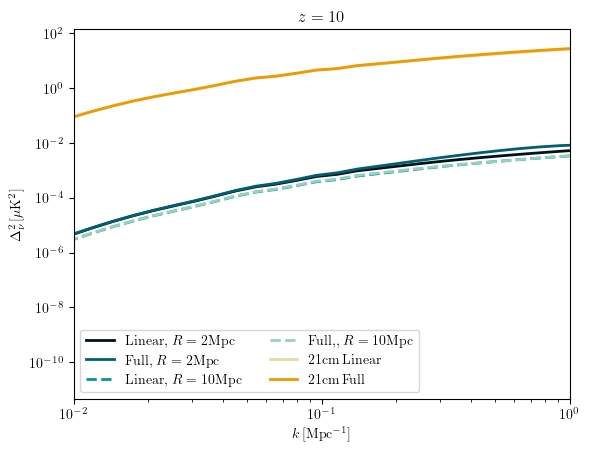

In [82]:
#choose a z to plot
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.title(r'$z = %g$'%zchoose)
plt.loglog(klist,PSLIM_small.Deltasq_LIM_lin[_iz], '-', label=r'$\rm Linear$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R)
plt.loglog(klist,PSLIM_small.Deltasq_LIM[_iz], '-', label=r'$\rm Full$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R)
plt.loglog(klist,PSLIM_large.Deltasq_LIM_lin[_iz], '--', label=r'$\rm Linear$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_large._R)
plt.loglog(klist,PSLIM_large.Deltasq_LIM[_iz], '--', label=r'$\rm Full,$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_large._R)
plt.loglog(klist,PS21.Deltasq_T21_lin[_iz], '-', label=r'$\rm 21cm\,Linear$')
plt.loglog(klist,PS21.Deltasq_T21[_iz], '-', label=r'$\rm 21cm\,Full$')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend(loc=3, ncol=2)

plt.xlim([1e-2,1])
#plt.ylim([1e-5,1e2])


We also compute the cross power spectrum between the matter density and LIM (and 21cm).

(0.01, 1)

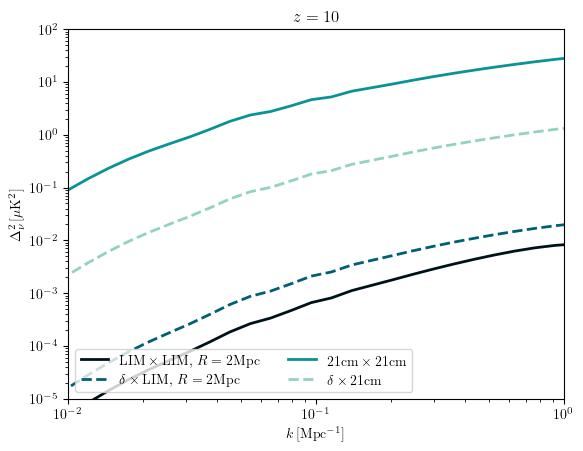

In [83]:
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

plt.title(r'$z = %g$'%zchoose)
plt.loglog(klist,PSLIM_small.Deltasq_LIM[_iz], '-', label=r'$\rm LIM\times LIM$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R)
plt.loglog(klist,PSLIM_small.Deltasq_dLIM[_iz], '--', label=r'$\rm \delta\times LIM$'+ r'$,\,R= %g{\rm Mpc}$'%LineParams_small._R)
plt.loglog(klist,PS21.Deltasq_T21[_iz], '-', label=r'$\rm 21cm \times 21cm$')
plt.loglog(klist,PS21.Deltasq_dT21[_iz], '--', label=r'$\rm \delta \times 21cm$')

plt.xlabel(r'$k\,\rm [Mpc^{-1}]$');
plt.ylabel(r'$\Delta^2_{\nu}\,[\mu{\rm K}^2]$');
plt.legend(loc=3, ncol=2)
plt.ylim([1e-5,1e2])

plt.xlim([1e-2,1])


Finally, we can produce map of the brightness temperature.

In the 21cm case, this is produced (using a lognormal distribution) by

1) define the $T_{21}^{\rm global}$ from the $T_{21}^{\rm avg}$ coefficients

2) interpolate $P_{21}^{\rm lin}(k)/(T_{21}^{\rm global})^2$

3) apply powerbox to get $\delta_{21}$

4) define the map through $T_{21}^{\rm global}(1+\delta_{21})$

In our case, we apply the same procedure using $\bar{I}_\nu$ instead of $T_{21}^{\rm global}$, since this is the observed quantity.

We look at maps produced using the linear and non-linear power spectra at different $z$ and different $R_0$ for LIM.

Cell size = 2.0 Mpc


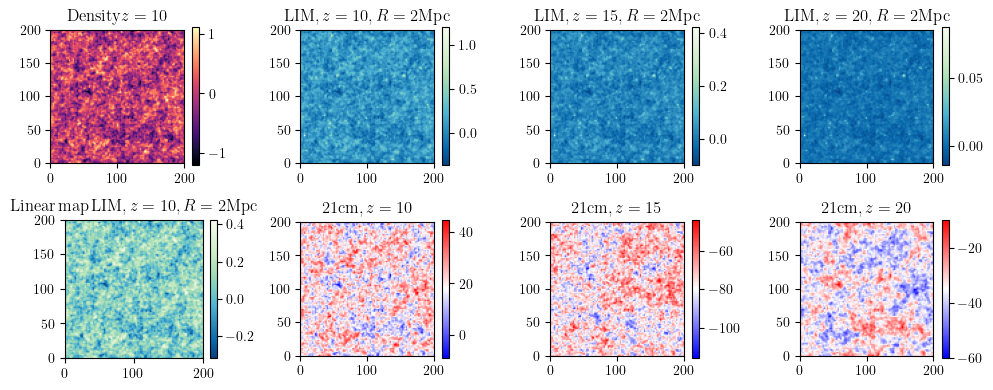

In [95]:
plt.figure(figsize=(10,4))
zval = 10.
Lbox = 200
Nbox = 100
Mapz = zeus21.CoevalMaps_LIM_zeuslike(CoeffStructure_small, PSLIM_small, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_15 = zeus21.CoevalMaps_LIM_zeuslike(CoeffStructure_small, PSLIM_small, PS21, 15., KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_20 = zeus21.CoevalMaps_LIM_zeuslike(CoeffStructure_small, PSLIM_small, PS21, 20., KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_21 = zeus21.CoevalMaps(CoeffStructure_21, PS21, zval, KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_21_15 = zeus21.CoevalMaps(CoeffStructure_21, PS21, 15., KIND=1, Lbox = Lbox, Nbox = Nbox)
Mapz_21_20 = zeus21.CoevalMaps(CoeffStructure_21, PS21, 20., KIND=1, Lbox = Lbox, Nbox = Nbox)
print('Cell size = ' + str(Lbox/Nbox) + ' Mpc')

_islice = 0

plt.subplot(241)
plt.imshow(Mapz.deltamap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap='magma')#,vmin=-0.6,vmax=0.6)
plt.title(r'${\rm Density}z = %g\,$'%zval )
plt.colorbar()

plt.subplot(242)
plt.imshow((Mapz.LIMmap[_islice]),extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap=get_cmap('GnBu_r')) 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_small._R)
plt.colorbar()

plt.subplot(243)
plt.imshow(Mapz_15.LIMmap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap=get_cmap('GnBu_r')) 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%15 + r'$R = %g{\rm Mpc}$'%LineParams_small._R)
plt.colorbar()

plt.subplot(244)
plt.imshow(Mapz_20.LIMmap[_islice],extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap=get_cmap('GnBu_r')) 
plt.title(r'${\rm LIM,\,}z = %g,\,$'%20 + r'$R = %g{\rm Mpc}$'%LineParams_small._R)
plt.colorbar()


plt.subplot(245)
im = plt.imshow((Mapz.LIMmap_lin[_islice]),extent=(0,Mapz.Lbox,0,Mapz.Lbox),cmap=get_cmap('GnBu_r')) 
plt.title(r'${\rm Linear\,map\,LIM,\,}z = %g,\,$'%zval + r'$R = %g{\rm Mpc}$'%LineParams_small._R)
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.subplot(246)
plt.imshow((Mapz_21.T21map[_islice]),extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%zval )
plt.colorbar()

plt.subplot(247)
plt.imshow(Mapz_21_15.T21map[_islice],extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%15 )
plt.colorbar()

plt.subplot(248)
plt.imshow(Mapz_21_20.T21map[_islice],extent=(0,Mapz_21.Lbox,0,Mapz_21.Lbox),cmap='bwr') 
plt.title(r'${\rm 21cm,\,}z = %g$'%20 )
plt.colorbar()

plt.tight_layout()
plt.show()

The difference between the maps is sourced by differences in the linear and non-linear power spectrum, which are more relevant for LIM.

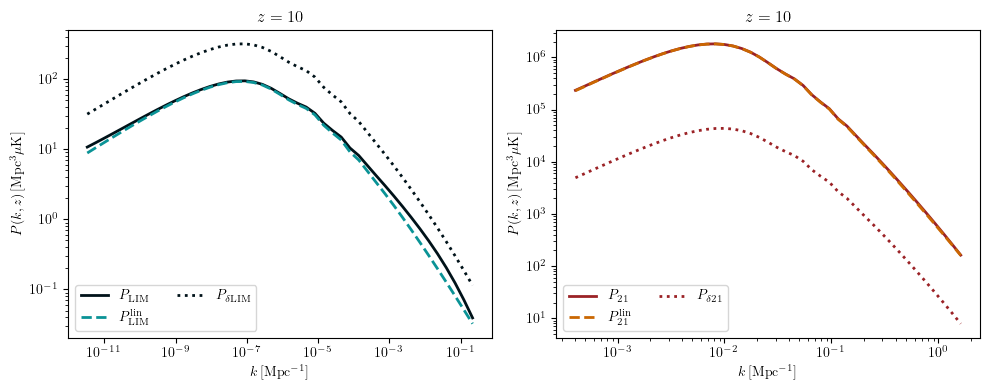

In [85]:
zchoose=10.;
_iz = min(range(len(zlist)), key=lambda i: np.abs(zlist[i]-zchoose))

klist_21 = PS21.klist_PS
k3over2pi2_21 = klist_21**3/(2*np.pi**2)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.loglog(k3over2pi2_21,PSLIM_small.Deltasq_LIM[_iz]/k3over2pi2_21, color=colors[0],ls='-', label=r'$P_{\rm LIM}$')
plt.loglog(k3over2pi2_21,PSLIM_small.Deltasq_LIM_lin[_iz]/k3over2pi2_21, color=colors[2], ls='--', label=r'$P_{\rm LIM}^{\rm lin}$')
plt.loglog(k3over2pi2_21,PSLIM_small.Deltasq_dLIM[_iz]/k3over2pi2_21, color=colors[0], ls=':', label=r'$P_{\delta{\rm LIM}}$')
plt.xlabel(r'$k\,{\rm [Mpc^{-1}]}$');
plt.ylabel(r'$P(k,z)\,[{\rm Mpc^3\mu K}]$');
plt.legend(loc=3, ncol=2)
plt.title(r'$z = %g$'%zchoose)

#plt.loglog(klist,PSLIM_small.Deltasq_dLIM_lin[_iz]/k3over2pi2, ':', label=r'$P_{\delta{\rm LIM}}^{\rm lin}$')

plt.subplot(122)
plt.loglog(klist_21,PS21.Deltasq_T21[_iz]/k3over2pi2_21, ls='-', label=r'$P_{\rm 21}$',color=colors[-1])
plt.loglog(klist_21,PS21.Deltasq_T21_lin[_iz]/k3over2pi2_21, ls='--', label=r'$P_{\rm 21}^{\rm lin}$',color=colors[-4])
plt.loglog(klist_21,PS21.Deltasq_dT21[_iz]/k3over2pi2_21, ls=':', label=r'$P_{\delta{\rm 21}}$',color=colors[-1])
#plt.loglog(klist,PS21.Deltasq_dT21_lin[_iz]/k3over2pi2, ':', label=r'$P_{\delta{\rm LIM}}^{\rm lin}$')

plt.xlabel(r'$k\,{\rm [Mpc^{-1}]}$');
plt.ylabel(r'$P(k,z)\,[{\rm Mpc^3\mu K}]$');
plt.legend(loc=3, ncol=2)
plt.title(r'$z = %g$'%zchoose)

plt.tight_layout()
